In [43]:
# The code was removed by Watson Studio for sharing.

# Segmenting and Clustering Neighborhoods in Toronto. Week 3 - Part 3

## HTML version with maps:

In [ ]:
https://jhhdez.site/projects/Clustering_Toronto_Week3_Part3.html

### Importing Dataframe generated on Part 2 from IBM bucket as df

In [44]:
# The code was removed by Watson Studio for sharing.

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494


### Installing & Importing libraries

In [45]:
try: # installing GeoPy
    print("Installing GeoPy...\n")
    !pip -q install geopy # convert an address into latitude and longitude values
    print("GeoPy has been successfully installed!\n")
except:
    print("ERROR: could not install GeoPy!\n")
from geopy.geocoders import Nominatim 

try: # installing Folium
    print("Installing Folium...\n")
    !pip -q install folium # map rendering library
    print("Folium has been successfully installed!\n")
except:
    print("ERROR: could not install Folium!\n")    
import folium 

import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors
from sklearn.cluster import KMeans # import k-means from clustering stage
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize
print('Libraries imported.')

Installing GeoPy...

GeoPy has been successfully installed!

Installing Folium...

Folium has been successfully installed!

Libraries imported.


### Define Foursquare Credentials and Version

In [4]:
# The code was removed by Watson Studio for sharing.

### Use geopy library to get the latitude and longitude values of Toronto.

In [46]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="ca_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


In [47]:
df.shape

(103, 5)

### Reducing Dataframe to Toronto Boroughs (East, West, Central & Downtown)

In [48]:
df.sort_values('Borough').head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
86,M4V,Central Toronto,"Summerhill West , Rathnelly , South Hill , ...",43.686412,-79.400049
79,M4S,Central Toronto,Davisville,43.704324,-79.388790
83,M4T,Central Toronto,"Moore Park , Summerhill East",43.689574,-79.383160
68,M5P,Central Toronto,Forest Hill North & West,43.696948,-79.411307
74,M5R,Central Toronto,"The Annex , North Midtown , Yorkville",43.672710,-79.405678


In [49]:
toronto = df[df['Borough'].astype(str).str.contains("Toronto")]
toronto.sort_values('Borough').head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
62,M5N,Central Toronto,Roselawn,43.711695,-79.416936
67,M4P,Central Toronto,Davisville North,43.712751,-79.390197
68,M5P,Central Toronto,Forest Hill North & West,43.696948,-79.411307
73,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
74,M5R,Central Toronto,"The Annex , North Midtown , Yorkville",43.672710,-79.405678


In [50]:
toronto.shape

(39, 5)

In [51]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, label in zip(toronto['Latitude'], toronto['Longitude'], toronto['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Adding Boroughs York & East York in order to make the study more representative

In [52]:
toronto_big = toronto
toronto_big = toronto_big.append(df[df['Borough'] =="East York"])
toronto_big = toronto_big.append(df[df['Borough'] =="York"])

In [53]:
# create map of Toronto using latitude and longitude values
map_toronto_big = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, label in zip(toronto_big['Latitude'], toronto_big['Longitude'], toronto_big['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_big)  
    
map_toronto_big

### Exploring Neighborhoods in Toronto Metropolitan

#### Function to request information using Foursqare API

In [54]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Calling the function on each neighborhood and creating a new dataframe called toronto_venues

In [34]:
LIMIT = 500 # limit of number of venues returned by Foursquare API

toronto_venues = getNearbyVenues(names=toronto_big['Neighborhood'],
                                   latitudes=toronto_big['Latitude'],
                                   longitudes=toronto_big['Longitude']
                                  )

Regent Park ,  Harbourfront
Queen's Park ,  Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond ,  Adelaide ,  King
Dufferin ,  Dovercourt Village
Harbourfront East ,  Union Station ,  Toronto Islands
Little Portugal ,  Trinity
The Danforth West ,  Riverdale
Toronto Dominion Centre ,  Design Exchange
Brockton ,  Parkdale Village ,  Exhibition Place
India Bazaar ,  The Beaches West
Commerce Court ,  Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park ,  The Junction South
North Toronto West
The Annex ,  North Midtown ,  Yorkville
Parkdale ,  Roncesvalles
Davisville
University of Toronto ,  Harbord
Runnymede ,  Swansea
Moore Park ,  Summerhill East
Kensington Market ,  Chinatown ,  Grange Park
Summerhill West ,  Rathnelly ,  South Hill ,  Forest Hill SE ,  Deer Park
CN Tower ,  King and Spadina ,  Railway Lands ,  Harbourfront West ,  Bathurst Quay ,  South

In [55]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park , Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park , Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park , Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
3,"Regent Park , Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
4,"Regent Park , Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


In [56]:
print('{} venues were returned by Foursquare.'.format(toronto_venues.shape[0]))

1717 venues were returned by Foursquare.


In [57]:
#backup
toronto_venues_backup = toronto_venues.copy()

### Number of Venues for each neighborhood

In [58]:
toronto_venues_count = toronto_venues.groupby('Neighborhood').count()
toronto_venues_count.drop(columns=['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude', 'Venue Category'], inplace=True)
toronto_venues_count.sort_values(by='Venue', ascending=False).head(10)

,Venue
Neighborhood,
"Garden District, Ryerson",100
"Toronto Dominion Centre , Design Exchange",100
"Commerce Court , Victoria Hotel",100
"First Canadian Place , Underground city",100
"Harbourfront East , Union Station , Toronto Islands",100
Stn A PO Boxes,96
"Richmond , Adelaide , King",93
St. James Town,82
Church and Wellesley,72


### Bar Chart - Distribution of Venues - Toronto Metropolitan Area

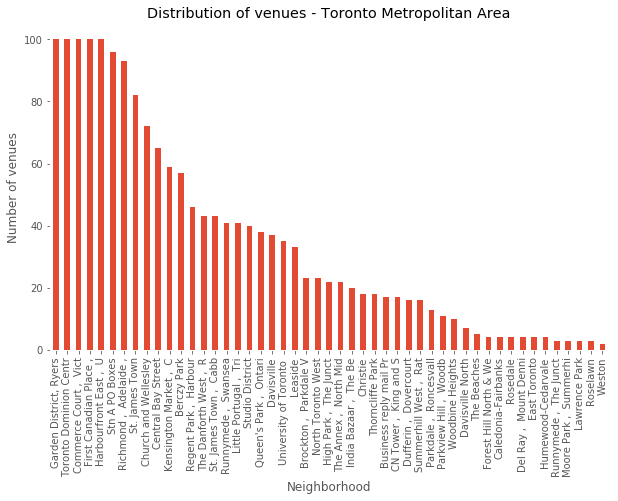

In [59]:
# first we need to short the string values of the column Neighborhood for better visual of labels on chart
toronto_venues_count_shorted = toronto_venues_count
toronto_venues_count_shorted.index = toronto_venues_count.index.str.slice(0,22)
toronto_venues_count_shorted.sort_values('Venue', ascending=False, inplace=True)

# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style
ax = toronto_venues_count.plot(kind='bar', figsize=(10, 6))

ax.set_facecolor('white') # remove background
ax.get_legend().remove() # remove legend
plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Number of venues') # add y-label to the plot
plt.title('Distribution of venues - Toronto Metropolitan Area') # add title to the plot

plt.show()

### Clustering the venues for a visual representation on a map

In [60]:
from folium import plugins

# let's start again with a clean copy of the map of San Francisco
toronto_venues_map = folium.Map(location = [latitude, longitude], zoom_start = 13)

# instantiate a mark cluster object for the incidents in the dataframe
category = plugins.MarkerCluster().add_to(toronto_venues_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(toronto_venues['Venue Latitude'], toronto_venues['Venue Longitude'], toronto_venues['Venue Category']):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(category)

# display map
toronto_venues_map

### Unique categories from all the returned venues

In [62]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 238 uniques categories.


In [63]:
toronto_venues_cat = toronto_venues.groupby('Venue Category').count()
toronto_venues_cat.drop(columns=['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude', 'Neighborhood'], inplace=True)
toronto_venues_cat.sort_values(by='Venue', ascending=False).head(10)

,Venue
Venue Category,
Coffee Shop,148
Café,92
Restaurant,58
Italian Restaurant,46
Park,43
Hotel,39
Japanese Restaurant,35
Bakery,29
Pizza Place,28


### Bar Chart - Distribution of Top 20 Venues Categories - Toronto Metropolitan Area

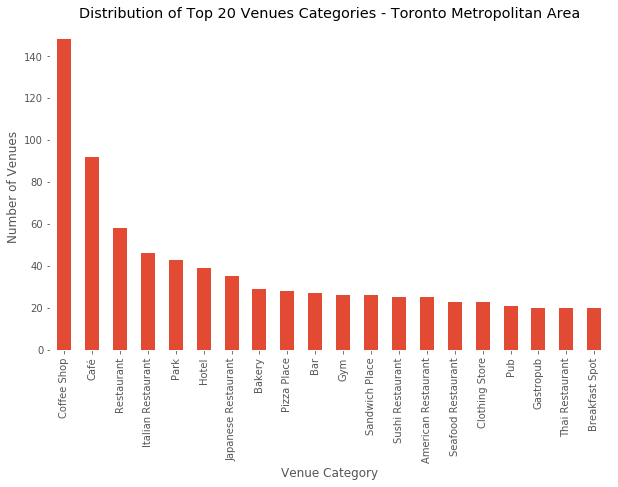

In [64]:
toronto_venues_cat.sort_values('Venue', ascending=False, inplace=True)
toronto_venues_cat_top = toronto_venues_cat.iloc[0:20, :]

mpl.style.use('ggplot') # optional: for ggplot-like style
ax = toronto_venues_cat_top.plot(kind='bar', figsize=(10, 6))

ax.set_facecolor('white') # remove background
ax.get_legend().remove() # remove legend
plt.xlabel('Venue Category') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Distribution of Top 20 Venues Categories - Toronto Metropolitan Area') # add title to the plot

plt.show()

### Analyze Each Neighborhood

In [65]:
#toronto_venues = toronto_venues.groupby('Neighborhood').count()
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
col_name='Neighborhood'
first_col = toronto_onehot.pop(col_name)
toronto_onehot.insert(0, col_name, first_col)

toronto_onehot.head()

,Neighborhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Women's Store,Yoga Studio
0,"Regent Park , Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Regent Park , Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [66]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.017544,0.0,0.0,0.0,0.0,0.000000,0.017544,0.0,0.017544,0.035088,0.0,0.000000,0.0,0.017544,0.017544,0.0,0.035088,0.0,0.0,0.0,0.017544,0.0,0.000000,0.0,0.000000,0.0,0.017544,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.035088,0.0,0.0,0.0,0.035088,0.0,0.0,0.0,0.000000,0.017544,0.052632,0.070175,0.0,0.0,0.0,0.0,0.0,0.017544,0.000000,0.017544,0.000000,0.0,0.0,0.0,0.0,0.017544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017544,0.0,0.0,0.0,0.0,0.0,0.0,0.017544,0.0,0.0,0.0,0.0,0.035088,0.000000,0.0,0.0,0.0,0.017544,0.0,0.0,0.0,0.0,0.0,0.017544,0.01

### Each neighborhood along with the top 5 most common venues

In [67]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.07
1        Cocktail Bar  0.05
2          Restaurant  0.04
3  Italian Restaurant  0.04
4                Café  0.04


----Brockton ,  Parkdale Village ,  Exhibition Place----
            venue  freq
0            Café  0.13
1  Breakfast Spot  0.09
2     Coffee Shop  0.09
3   Grocery Store  0.04
4          Bakery  0.04


----Business reply mail Processing CentrE----
                  venue  freq
0           Yoga Studio  0.06
1                   Spa  0.06
2  Gym / Fitness Center  0.06
3         Garden Center  0.06
4    Light Rail Station  0.06


----CN Tower ,  King and Spadina ,  Railway Lands ,  Harbourfront West ,  Bathurst Quay ,  South Niagara ,  Island airport----
                venue  freq
0     Airport Service  0.18
1      Airport Lounge  0.12
2    Airport Terminal  0.12
3             Airport  0.06
4  Airport Food Court  0.06


----Caledonia-Fairbanks----
                 venue  freq
0                 Park  0

### Putting the information into a pandas dataframe

In [68]:
# function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [69]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Bakery,Italian Restaurant,Cheese Shop,Café,Restaurant,Seafood Restaurant,Beer Bar
1,"Brockton , Parkdale Village , Exhibition Place",Café,Breakfast Spot,Coffee Shop,Yoga Studio,Gym,Pet Store,Performing Arts Venue,Nightclub,Italian Restaurant,Intersection
2,Business reply mail Processing CentrE,Yoga Studio,Spa,Gym / Fitness Center,Garden Center,Fast Food Restaurant,Farmers Market,Light Rail Station,Comic Shop,Pizza Place,Butcher
3,"CN Tower , King and Spadina , Railway Lands ...",Airport Service,Airport Lounge,Airport Terminal,Airport,Harbor / Marina,Coffee Shop,Plane,Sculpture Garden,Boutique,Bar
4,Caledonia-Fairbanks,Park,Women's Store,Pool,Deli / Bodega,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


#### (creating a copy of the variable in order to use it with different K-values)

In [71]:
#creating a copy of the variable in order to use it with different K-values

neighborhoods_venues_sorted_k8 = neighborhoods_venues_sorted.copy()
neighborhoods_venues_sorted_k4 = neighborhoods_venues_sorted.copy()
toronto_grouped_k8 = toronto_grouped.copy()
toronto_grouped_k4 = toronto_grouped.copy()

In [72]:
toronto_grouped.shape

(49, 238)

### Clustering Neighborhoods using k-means in 8 k-clusters

In [73]:
# set number of clusters
kclusters = 8

toronto_grouped_clustering_k8 = toronto_grouped_k8.drop('Neighborhood', 1)

# run k-means clustering
kmeans_k8 = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering_k8)

# check cluster labels generated for each row in the dataframe
kmeans_k8.labels_[0:10] 

array([3, 3, 3, 3, 5, 3, 3, 3, 3, 3], dtype=int32)

#### New dataframe toronto_merged_k8 that includes the cluster as well as the top 10 venues for each neighborhood

In [74]:
# add clustering labels
neighborhoods_venues_sorted_k8.insert(0, 'Cluster Labels', kmeans_k8.labels_)

toronto_merged_k8 = toronto_big.copy()

# merge toronto_grouped with toronto_big to add latitude/longitude for each neighborhood
toronto_merged_k8 = toronto_merged_k8.join(neighborhoods_venues_sorted_k8.set_index('Neighborhood'), on='Neighborhood')

toronto_merged_k8.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636,3,Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Café,Theater,Mexican Restaurant,Shoe Store,Restaurant
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494,3,Coffee Shop,Sushi Restaurant,Diner,Yoga Studio,Creperie,Spa,Sandwich Place,Burger Joint,Burrito Place,Café
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,3,Clothing Store,Coffee Shop,Café,Cosmetics Shop,Middle Eastern Restaurant,Bubble Tea Shop,Restaurant,Japanese Restaurant,Tea Room,Theater
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,3,Coffee Shop,Café,Gastropub,Cocktail Bar,American Restaurant,Italian Restaurant,Lingerie Store,Moroccan Restaurant,Cosmetics Shop,Creperie
19,M4E,East Toronto,The Beaches,43.676357,-79.293031,3,Pub,Coffee Shop,Health Food Store,Trail,Yoga Studio,Dog Run,Dessert Shop,Diner,Discount Store,Distribution Center


In [75]:
toronto_merged_k8.groupby('Cluster Labels').count()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
3,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37
4,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


### Clustering again with 4 K-clusters in order to compare results

In [76]:
kclusters = 4

toronto_grouped_clustering_k4 = toronto_grouped_k4.drop('Neighborhood', 1)

# run k-means clustering
kmeans_k4 = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering_k4)

# add clustering labels
neighborhoods_venues_sorted_k4.insert(0, 'Cluster Labels', kmeans_k4.labels_)

toronto_merged_k4 = toronto_big.copy()

# merge toronto_grouped with toronto_big to add latitude/longitude for each neighborhood
toronto_merged_k4 = toronto_merged_k4.join(neighborhoods_venues_sorted_k4.set_index('Neighborhood'), on='Neighborhood')

toronto_merged_k4.groupby('Cluster Labels').count()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,,
0,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40
1,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


# We have obtained the same results with different K-Clusters values. We observe a huge concentration in city center

#### Visual representation on a map of the resulting clusters

In [77]:
# create map for K-Clusters 4
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)
kclusters = 4
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged_k4['Latitude'], toronto_merged_k4['Longitude'], toronto_merged_k4['Neighborhood'], toronto_merged_k4['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

#### Cluster 1

In [78]:
toronto_merged_k4.loc[toronto_merged_k4['Cluster Labels'] == 0, toronto_merged_k4.columns[[1] + list(range(5, toronto_merged_k4.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,0,Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Café,Theater,Mexican Restaurant,Shoe Store,Restaurant
4,Downtown Toronto,0,Coffee Shop,Sushi Restaurant,Diner,Yoga Studio,Creperie,Spa,Sandwich Place,Burger Joint,Burrito Place,Café
9,Downtown Toronto,0,Clothing Store,Coffee Shop,Café,Cosmetics Shop,Middle Eastern Restaurant,Bubble Tea Shop,Restaurant,Japanese Restaurant,Tea Room,Theater
15,Downtown Toronto,0,Coffee Shop,Café,Gastropub,Cocktail Bar,American Restaurant,Italian Restaurant,Lingerie Store,Moroccan Restaurant,Cosmetics Shop,Creperie
19,East Toronto,0,Pub,Coffee Shop,Health Food Store,Trail,Yoga Studio,Dog Run,Dessert Shop,Diner,Discount Store,Distribution Center
20,Downtown Toronto,0,Coffee Shop,Cocktail Bar,Farmers Market,Bakery,Italian Restaurant,Cheese Shop,Café,Restaurant,Seafood Restaurant,Beer Bar
24,Downtown Toronto,0,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Burger Joint,Ice Cream Shop,Thai Restaurant,Middle Eastern Restaurant,Fried Chicken Joint,Japanese Restaurant
25,Downtown Toronto,0,Grocery Store,Café,Park,Italian Restaurant,Restaurant,Baby Store,Athletics & Sports,Diner,Candy Store,Coffee Shop
30,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Gym,Deli / Bodega,American Restaurant,Clothing Store,Thai Restaurant,Hotel,Sushi Restaurant
31,West Toronto,0,Pharmacy,Bakery,Grocery Store,Athletics & Sports,Gym / Fitness Center,Middle Eastern Restaurant,Music Venue,Pizza Place,Café,Brewery


#### Cluster 2

In [79]:
toronto_merged_k4.loc[toronto_merged_k4['Cluster Labels'] == 1, toronto_merged_k4.columns[[1] + list(range(5, toronto_merged_k4.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
61,Central Toronto,1,Park,Swim School,Bus Line,Department Store,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
68,Central Toronto,1,Park,Jewelry Store,Trail,Sushi Restaurant,Yoga Studio,Deli / Bodega,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
83,Central Toronto,1,Park,Playground,Trail,Dance Studio,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
91,Downtown Toronto,1,Park,Playground,Trail,Dance Studio,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
16,York,1,Park,Field,Hockey Arena,Trail,Yoga Studio,Dog Run,Dessert Shop,Diner,Discount Store,Distribution Center
21,York,1,Park,Women's Store,Pool,Deli / Bodega,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


#### Cluster 3

In [80]:
toronto_merged_k4.loc[toronto_merged_k4['Cluster Labels'] == 2, toronto_merged_k4.columns[[1] + list(range(5, toronto_merged_k4.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,East York,2,Park,Coffee Shop,Convenience Store,Deli / Bodega,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
64,York,2,Park,Convenience Store,Deli / Bodega,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


#### Cluster 4

In [81]:
toronto_merged_k4.loc[toronto_merged_k4['Cluster Labels'] == 3, toronto_merged_k4.columns[[1] + list(range(5, toronto_merged_k4.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
62,Central Toronto,3,Pool,Health & Beauty Service,Garden,Yoga Studio,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run
